# 03 Simulating an experiment

Currently liionpack only supports constant current experiments but it is our intention to implement the full PyBaMM experiment functionality in due course. Let's get started by importing the packages.

In [1]:
!pip install -q git+https://github.com/pybamm-team/liionpack.git@main
import liionpack as lp
import pybamm
import numpy as np
import matplotlib.pyplot as plt

Set up the circuit

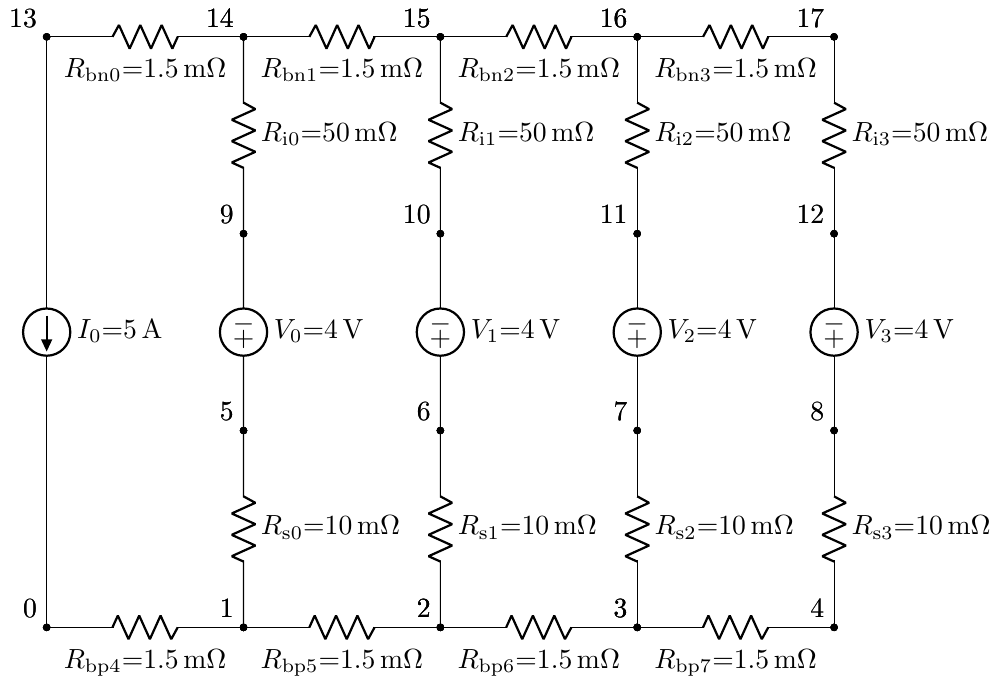

In [23]:
# Generate the netlist
netlist = lp.setup_circuit(Np=4, Ns=1, Rb=1.5e-3, Rc=1e-2, Ri=5e-2, V=4.0, I=5.0)
lp.draw_circuit(netlist, cpt_size=1.0, dpi=200, node_spacing=2.5)

Set up the output variables and heat transfer coefficients and battery parameters.

In [3]:
output_variables = [
    "X-averaged negative particle surface concentration [mol.m-3]",
    "X-averaged positive particle surface concentration [mol.m-3]",
]


# PyBaMM parameters
chemistry = pybamm.parameter_sets.Chen2020
parameter_values = pybamm.ParameterValues(chemistry=chemistry)

Now define the experiment as a constant current discharge for 1000 seconds followed by a rest of 1000 seconds followed by a constant current charge of 1000 seconds, repeated three times with a 10 second period. The period in PyBaMM determines the output data reporting period but here it also determines the global time step. This means that when solving the problem the local currents are held fixed for a period of 10 seconds and then a the new cell internal resistances and open circuit voltages are used to solve the circuit and new currents are determined by the global balance.

In [4]:
# Cycling experiment
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 5 A for 1000 s or until 3.3 V",
            "Rest for 1000 s",
            "Charge at 5 A for 1000 s or until 4.1 V",
            "Rest for 1000 s",
        )
    ]
    * 3,
    period="10 s",
)

Now we have out experiment we can take a look at the steps involved

In [5]:
experiment.operating_conditions

[{'electric': (5.0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None},
 {'electric': (0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None},
 {'electric': (-5.0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None},
 {'electric': (0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None},
 {'electric': (5.0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None},
 {'electric': (0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None},
 {'electric': (-5.0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None},
 {'electric': (0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None},
 {'electric': (5.0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None},
 {'electric': (0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None},
 {'electric': (-5.0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None},
 {'electric': (0, 'A'), 'time': 1000.0, 'period': 10.0, 'dc_data': None}]

Currently, this is the only information used by liionpack and voltage limits are ignored. There is also some additional checks that take place behind the scenes. The current must be specified in [A] and not in [C] and the time for each step must be an integer multiple of the period.

In [6]:
# Cycling experiment
bad_exp_1 = pybamm.Experiment([("Discharge at 5 C for 1000 s",)] * 3, period="10 s")

bad_exp_2 = pybamm.Experiment([("Discharge at 5 A for 999 s",)] * 3, period="10 s")

These bad experiments will be acceptable to PyBaMM and there is no error thrown but the liionpack solver will not like them. We can check what the protocol looks like using the `generate_protocol_from_experiment` function, and this will return a list of currents that are applied at each timestep.

Text(0, 0.5, 'Current [A]')

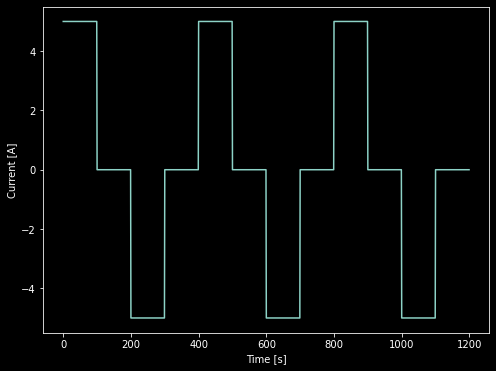

In [27]:
protocol = lp.generate_protocol_from_experiment(experiment)
plt.figure(figsize=(8, 6))
plt.plot(protocol)
plt.xlabel("Time [s]")
plt.ylabel("Current [A]")

Let's solve the problem and view the results

In [8]:
# Solve pack
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    output_variables=output_variables,
)

Stepping simulation: 100%|████████████████████████████████████████████████████████| 1200/1200 [00:11<00:00, 106.45it/s]


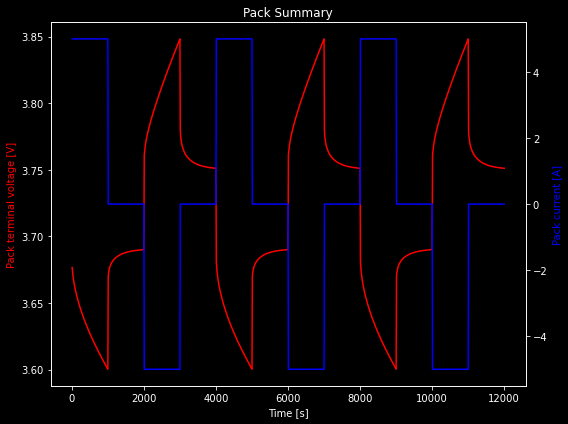

In [9]:
lp.plot_pack(output)